[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_E_update.ipynb)

# オートエンコーダによる画像のデノイジング

以下のセルでオートエンコーダを使ったデノイジングを試すことができます。

Epoch [1/10], Loss: 0.0308
Epoch [2/10], Loss: 0.0223
Epoch [3/10], Loss: 0.0213
Epoch [4/10], Loss: 0.0187
Epoch [5/10], Loss: 0.0161
Epoch [6/10], Loss: 0.0151
Epoch [7/10], Loss: 0.0165
Epoch [8/10], Loss: 0.0174
Epoch [9/10], Loss: 0.0142
Epoch [10/10], Loss: 0.0160
Test Loss: 0.0152


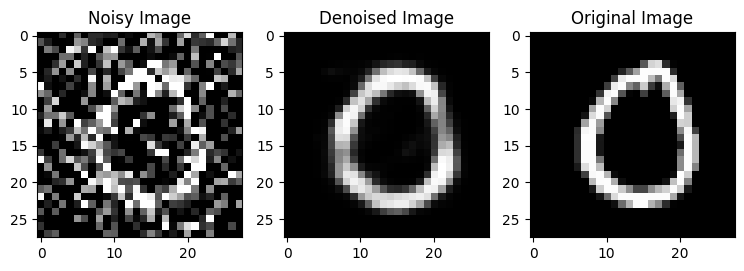

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# データの前処理
transform = transforms.Compose([transforms.ToTensor()])

# MNISTデータセットの読み込み
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# オートエンコーダの定義
class Autoencoder(nn.Module):
    def __init__(self, hidden_dim1=128, hidden_dim2=64):
        super(Autoencoder, self).__init__()
        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
        )
        # デコーダ
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, 28*28),
            nn.Sigmoid()  # ピクセル値を[0, 1]にスケーリング
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# モデルの初期化
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練関数
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.view(-1, 28 * 28)
            # ノイズの追加
            noisy_img = img + 0.5 * torch.randn(img.shape)  # ノイズを加える
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            # 順伝搬と損失計算
            output = model(noisy_img)
            loss = criterion(output, img)

            # 逆伝搬と最適化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 訓練の実行
train(model, train_loader, criterion, optimizer, num_epochs=10)

# 結果の可視化
def show_images(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            img, _ = data
            img = img.view(-1, 28 * 28)
            noisy_img = img + 0.5 * torch.randn(img.shape)
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            output = model(noisy_img)
            output = output.view(-1, 1, 28, 28)

            # ノイズ付き画像、再構成画像、元の画像を表示
            fig, axes = plt.subplots(1, 3, figsize=(9, 3))
            axes[0].imshow(noisy_img.view(-1, 1, 28, 28)[0].cpu().numpy().squeeze(), cmap='gray')
            axes[0].set_title("Noisy Image")
            axes[1].imshow(output[0].cpu().numpy().squeeze(), cmap='gray')
            axes[1].set_title("Denoised Image")
            axes[2].imshow(img.view(-1, 1, 28, 28)[0].cpu().numpy().squeeze(), cmap='gray')
            axes[2].set_title("Original Image")
            plt.show()
            break

# テストデータセットの読み込み
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# テスト関数の定義
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(-1, 28 * 28)
            # ノイズの追加
            noisy_img = img + 0.5 * torch.randn(img.shape)
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            # モデルの出力と損失の計算
            output = model(noisy_img)
            loss = criterion(output, img)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')

# テストデータでの評価
evaluate(model, test_loader, criterion)

# 結果の表示
show_images(model, train_loader)


Training with hidden_dim1=2, hidden_dim2=1
Epoch [1/5], Loss: 0.0691
Epoch [2/5], Loss: 0.0665
Epoch [3/5], Loss: 0.0642
Epoch [4/5], Loss: 0.0604
Epoch [5/5], Loss: 0.0620
Test Loss for hidden_dim1=2: 0.0675
Training with hidden_dim1=4, hidden_dim2=2
Epoch [1/5], Loss: 0.0641
Epoch [2/5], Loss: 0.0613
Epoch [3/5], Loss: 0.0599
Epoch [4/5], Loss: 0.0603
Epoch [5/5], Loss: 0.0657
Test Loss for hidden_dim1=4: 0.0618
Training with hidden_dim1=8, hidden_dim2=4
Epoch [1/5], Loss: 0.0595
Epoch [2/5], Loss: 0.0517
Epoch [3/5], Loss: 0.0503
Epoch [4/5], Loss: 0.0499
Epoch [5/5], Loss: 0.0543
Test Loss for hidden_dim1=8: 0.0518
Training with hidden_dim1=16, hidden_dim2=8
Epoch [1/5], Loss: 0.0556
Epoch [2/5], Loss: 0.0549
Epoch [3/5], Loss: 0.0458
Epoch [4/5], Loss: 0.0474
Epoch [5/5], Loss: 0.0488
Test Loss for hidden_dim1=16: 0.0483
Training with hidden_dim1=32, hidden_dim2=16
Epoch [1/5], Loss: 0.0453
Epoch [2/5], Loss: 0.0344
Epoch [3/5], Loss: 0.0327
Epoch [4/5], Loss: 0.0305
Epoch [5/5], 

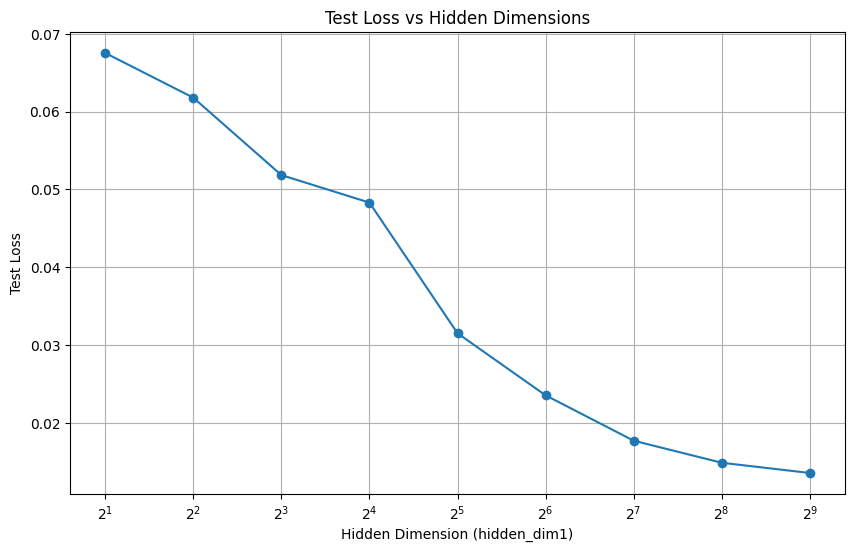

In [4]:
import numpy as np

# Test lossを記録するリスト
hidden_dims = [2**i for i in range(1, 10)]  # 2, 4, ..., 512
test_losses = []

# 各hidden_dimでのモデル訓練と評価
for hidden_dim in hidden_dims:
    print(f"Training with hidden_dim1={hidden_dim}, hidden_dim2={hidden_dim//2}")

    # モデルの初期化
    model = Autoencoder(hidden_dim1=hidden_dim, hidden_dim2=hidden_dim//2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # モデルの訓練
    train(model, train_loader, criterion, optimizer, num_epochs=5)

    # テストデータでの評価
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(-1, 28 * 28)
            noisy_img = img + 0.5 * torch.randn(img.shape)
            noisy_img = torch.clamp(noisy_img, 0., 1.)
            output = model(noisy_img)
            loss = criterion(output, img)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss for hidden_dim1={hidden_dim}: {avg_loss:.4f}")
    test_losses.append(avg_loss)

# 結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(hidden_dims, test_losses, marker='o')
plt.xscale('log', base=2)
plt.xlabel("Hidden Dimension (hidden_dim1)")
plt.ylabel("Test Loss")
plt.title("Test Loss vs Hidden Dimensions")
plt.grid(True)
plt.show()
